In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import mcu
import swiss_roll_dataset_generator
from importlib import reload

In [4]:
reload(mcu)
reload(swiss_roll_dataset_generator)

np.random.seed(179)
control_vars = swiss_roll_dataset_generator.get_control_vars(swiss_roll_dataset_generator.get_p())
response_matrix = swiss_roll_dataset_generator.generate_array_of_swiss_rolls(control_vars)
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = mcu.prepare_data(control_vars, response_matrix)
q = mcu.solve_semidefinite_programming(standardized_x, centered_y, edges)

                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Jan 13 09:02:31 PM: Your problem has 40000 variables, 1095 constraints, and 0 parameters.
(CVXPY) Jan 13 09:02:32 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 13 09:02:32 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 13 09:02:32 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 13 09:02:32 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 13 09:02:32 PM: Compiling problem (target solver=SCS).

/home/glebka/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


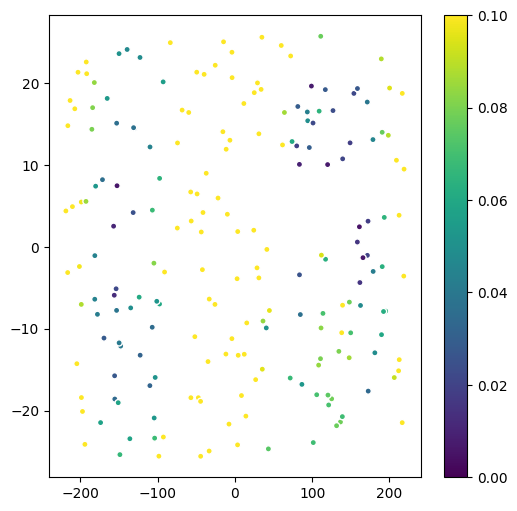

0.08227727174977234


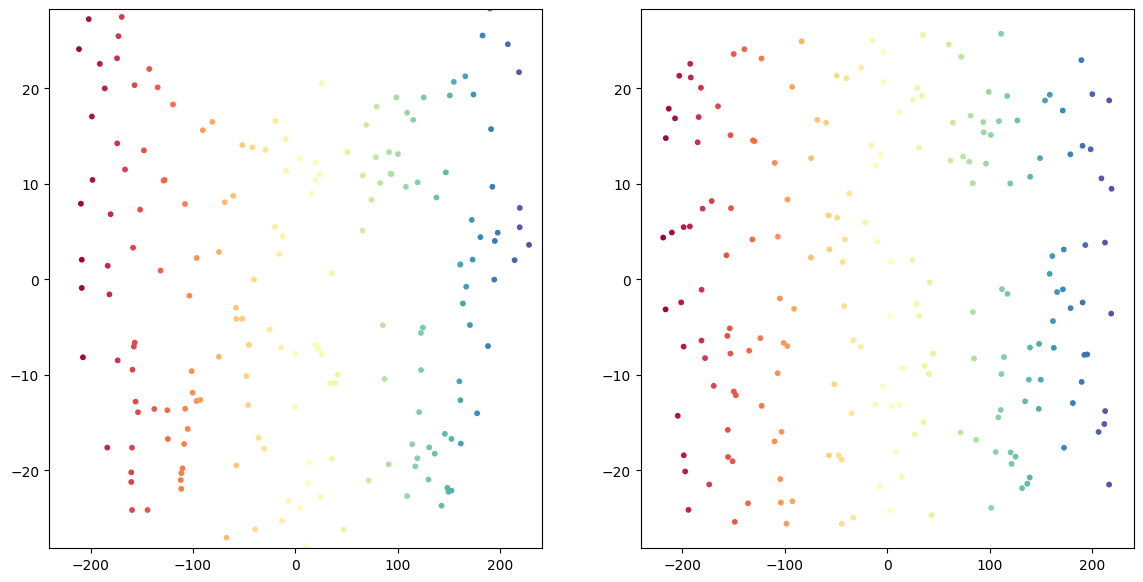

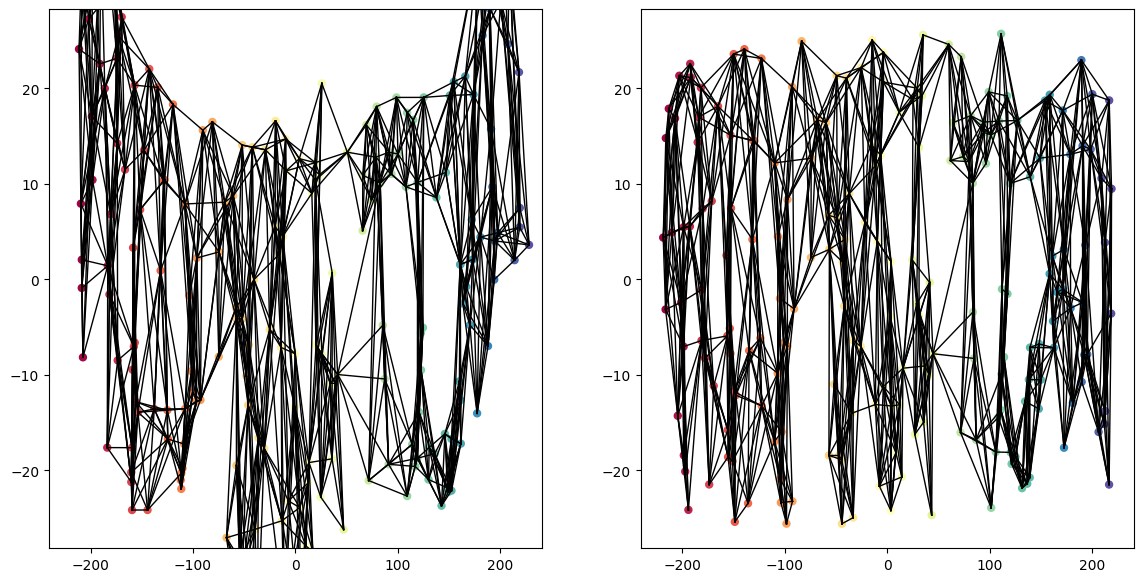

In [5]:
m_ = control_vars.shape[1]
# m_ = get_optimal_dimensionality(s)
ld_embedding = mcu.reduce_dimensions(q, m_)
regression_matrix = mcu.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

rre = mcu.compute_rre(ld_embedding, reconstructed_y)
mcu.plot_rre_heatmap(rre, reconstructed_y)
print(np.median(rre))
mcu.plot_two_embeddings(ld_embedding, reconstructed_y)
mcu.plot_two_embeddings_with_edges(ld_embedding, reconstructed_y, edges)

In [1]:
n_of_tests = 100
test_control_vars = swiss_roll_dataset_generator.get_control_vars(swiss_roll_dataset_generator.get_p(), n_of_tests)
test_rolls = swiss_roll_dataset_generator.generate_array_of_swiss_rolls(test_control_vars, n_of_tests)
x_opts = []
for (roll, control_var) in zip(test_rolls, test_control_vars):
    x_opt, x_err = mcu.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler)
    x_opt = x_opt * x_stds + x_means
    x_opts.append(x_opt)
    print("-----------")
    print(f"x_opt  = {x_opt}, x_err = {x_err}")
    print(f"x_real = {control_var}")

x_ops = np.array(x_opts)
test_control_vars = np.array(test_control_vars)

NameError: name 'swiss_roll_dataset_generator' is not defined

[0.69100485 0.23240303 3.3960947  0.57737528 0.38485887 0.51754641
 0.80710617 1.70862677 0.27424207 1.12271544 1.70850927 5.76018717
 1.48177324 3.98834952 4.39345269 0.33436645 3.53684239 2.01747851
 1.86812913 1.08272486 0.90513171 3.93497081 4.26298592 1.29510513
 0.94452205 0.29979375 0.87751703 0.73860622 1.5193545  2.31294703
 2.97218323 0.36054107 0.83071735 1.53943567 3.30818114 0.67398422
 1.37387852 1.4657091  1.49642897 1.34368    1.54973668 3.42547567
 1.99211449 0.15194646 0.33515372 1.31088559 3.8249157  2.89605734
 1.76978    4.28589307 0.70155804 2.83175245 1.80993652 1.51808682
 0.95066311 0.57462502 0.7938956  0.84725891 0.24723432 1.45564475
 0.63564588 2.76214315 3.36728668 0.73838897 1.89916652 1.88088773
 1.07550895 0.3776284  2.36356511 3.74589283 3.17676662 0.54045904
 0.12360944 0.53948006 2.53363374 1.07441037 0.63545256 1.27250156
 1.03010654 2.29059091 1.22725448 1.79641582 1.46673545 0.39490034
 2.12459606 0.66883747 1.77044466 0.44069326 4.93164458 0.2087

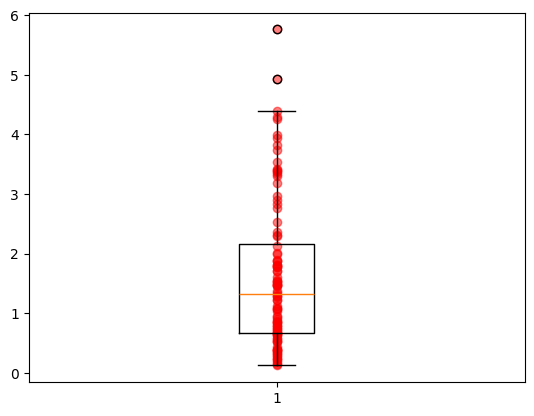

In [7]:
errors = np.linalg.norm(x_opts - test_control_vars, axis = 1)
plt.boxplot(errors)
plt.scatter(np.ones_like(errors), errors, alpha=0.5, color='red')
print(errors)
print(f"Median of errors = {np.median(errors)}")